# Regression task 1

### **Bayesian Logistic Regression Model**:

The model is a **Bayesian Logistic Regression** designed to predict the probability of a **home win** in football matches based on the **mean odds** of various bookmakers. This approach helps quantify uncertainty.

The structure of the model is as follows:

#### **1. Priors:**
- **Intercept $\beta_0$**: The intercept term, representing the log-odds of a home win when the home odds are at their mean, follows a normal distribution with a mean of 0 and a standard deviation of 2. This reflects a belief that the intercept is likely close to 0, with moderate uncertainty.

- **Slope $\beta_1$**: The coefficient for the scaled home odds follows a normal distribution with a mean of 0 and a **very narrow standard deviation of 0.1**, indicating a strong prior belief that the effect of the home odds on the probability of a home win is relatively small and precise.

#### **2. Model Structure:**
The model assumes that the **log-odds** of a home win are linearly related to the scaled home odds:
$$ \text{logit}(p) = \beta_0 + \beta_1 \times \text{scaled\_odds\_home} $$
where:
- $p$ is the probability of a home win.
- $beta_0$ is the intercept (baseline log-odds).
- $beta_1$ is the slope, which quantifies the effect of the scaled home odds on the log-odds of a home win.

The **sigmoid function** is then applied to the log-odds to map the result into the probability space:
$$ p = \text{sigmoid}(\beta_0 + \beta_1 \times \text{scaled\_odds\_home}) $$

#### **3. Likelihood:**
The outcome (whether a home team wins or not) is modeled using a **Bernoulli distribution**, where the observed outcome is binary (1 for win, 0 for loss/draw), and the probability of success is derived from the logistic regression model.

#### **4. Sampling and Inference:**
Posterior distributions for the parameters $\beta_0$ and $\beta_1$ are estimated using **Markov Chain Monte Carlo (MCMC)** sampling. The model is run with 1000 samples to obtain the posterior distribution for each parameter, which quantifies the uncertainty around their true values.

In [1]:
import pandas as pd
import os
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv('cleaned_football_data.csv')

# Split data by league and season
serie_a_data = data[data['League'] == 'Serie A']
pl_data = data[data['League'] == 'Premier League']

display(serie_a_data.head())
display(pl_data.head())

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgA,PSCH,PSCD,PSCA,Season,League,LBH,LBD,LBA,HomeWin
3040,I1,24/08/2019,Parma,Juventus,0,1,A,0.0,1.0,A,...,1.31,9.60,5.20,1.37,2019,Serie A,2.87875,4.095724,5.192526,0
3041,I1,24/08/2019,Fiorentina,Napoli,3,4,A,1.0,2.0,A,...,1.76,4.52,3.72,1.85,2019,Serie A,2.87875,4.095724,5.192526,0
3042,I1,25/08/2019,Udinese,Milan,1,0,H,0.0,0.0,D,...,2.06,4.03,3.43,2.04,2019,Serie A,2.87875,4.095724,5.192526,1
3043,I1,25/08/2019,Cagliari,Brescia,0,1,A,0.0,0.0,D,...,4.45,1.83,3.67,4.75,2019,Serie A,2.87875,4.095724,5.192526,0
3044,I1,25/08/2019,Roma,Genoa,3,3,D,2.0,2.0,D,...,7.13,1.75,3.69,5.32,2019,Serie A,2.87875,4.095724,5.192526,0


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgA,PSCH,PSCD,PSCA,Season,League,LBH,LBD,LBA,HomeWin
0,E0,09/08/2019,Liverpool,Norwich,4,1,H,4.0,0.0,H,...,19.83,1.14,10.43,19.63,2019,Premier League,2.953658,4.099487,5.155421,1
1,E0,10/08/2019,West Ham,Man City,0,5,A,0.0,1.0,A,...,1.25,11.11,6.68,1.27,2019,Premier League,2.953658,4.099487,5.155421,0
2,E0,10/08/2019,Bournemouth,Sheffield United,1,1,D,0.0,0.0,D,...,3.83,1.98,3.67,4.06,2019,Premier League,2.953658,4.099487,5.155421,0
3,E0,10/08/2019,Burnley,Southampton,3,0,H,0.0,0.0,D,...,2.78,2.71,3.19,2.90,2019,Premier League,2.953658,4.099487,5.155421,1
4,E0,10/08/2019,Crystal Palace,Everton,0,0,D,0.0,0.0,D,...,2.40,3.37,3.45,2.27,2019,Premier League,2.953658,4.099487,5.155421,0


In [3]:
# Calculate the mean of home odds
home_odds_columns = ['B365H', 'BWH', 'IWH', 'PSH', 'VCH', 'WHH']
odds_home = data[home_odds_columns].values
home_win = data['HomeWin'].values

# 2. Bayesian Logistic Regression Model with Strong Prior for beta_1
with pm.Model() as model:
    # Priors for intercept (moderate prior) and coefficient (strong prior)
    beta_0 = pm.Normal('beta_0', mu=0, sigma=2)
    beta = pm.Normal('beta', mu=0, sigma = 1, shape=len(home_odds_columns))  # Very strong prior on beta_1 (tight distribution)

    # Logistic regression model (log-odds to probability)
    logit_p = beta_0 + pm.math.dot(odds_home, beta)  # Linear combination
    #p = pm.Deterministic('p', pm.math.sigmoid(logit_p))  # Logistic function for probability

    # Likelihood: Observed outcomes are binary (home win: 1, loss/draw: 0)
    observed = data['HomeWin']  # Binary outcomes (1 for home win, 0 otherwise)
    y = pm.Bernoulli('y', logit_p=logit_p, observed=observed)

    # Sampling the posterior
    trace = pm.sample(1000, return_inferencedata=True)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 117 seconds.


In [5]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,1.501,0.081,1.352,1.652,0.002,0.001,2588.0,2833.0,1.0
beta[0],0.361,0.270,-0.177,0.832,0.005,0.004,2862.0,2677.0,1.0
beta[1],-1.057,0.239,-1.501,-0.610,0.005,0.003,2494.0,2501.0,1.0
beta[2],-0.098,0.088,-0.266,0.063,0.001,0.001,3665.0,3039.0,1.0
beta[3],-0.432,0.182,-0.778,-0.079,0.003,0.003,2822.0,2267.0,1.0
beta[4],0.376,0.255,-0.059,0.900,0.005,0.004,2409.0,2945.0,1.0
beta[5],0.178,0.295,-0.380,0.736,0.006,0.004,2633.0,2569.0,1.0


In [6]:
az.summary(trace, var_names=['beta_0', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,1.501,0.081,1.352,1.652,0.002,0.001,2588.0,2833.0,1.0
beta[0],0.361,0.270,-0.177,0.832,0.005,0.004,2862.0,2677.0,1.0
beta[1],-1.057,0.239,-1.501,-0.610,0.005,0.003,2494.0,2501.0,1.0
beta[2],-0.098,0.088,-0.266,0.063,0.001,0.001,3665.0,3039.0,1.0
beta[3],-0.432,0.182,-0.778,-0.079,0.003,0.003,2822.0,2267.0,1.0
beta[4],0.376,0.255,-0.059,0.900,0.005,0.004,2409.0,2945.0,1.0
beta[5],0.178,0.295,-0.380,0.736,0.006,0.004,2633.0,2569.0,1.0


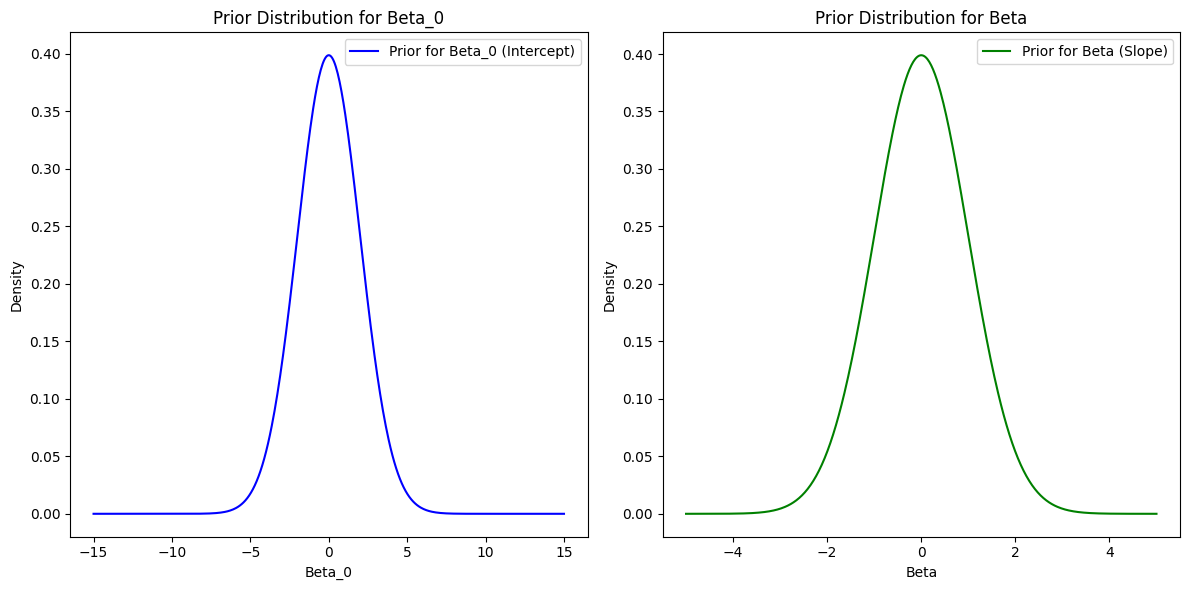

In [7]:
# Plot priors
x_beta_0 = np.linspace(-15, 15, 500)  # Range for intercept
x_beta_1 = np.linspace(-5, 5, 500)   # Range for slope

# Prior distributions
prior_beta_0 = np.exp(-0.5 * (x_beta_0 / 2)**2) / (1 * np.sqrt(2 * np.pi))  # N(0, 1)
prior_beta_1 = np.exp(-0.5 * (x_beta_1 / 1)**2) / (1 * np.sqrt(2 * np.pi))  # N(0, 1)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_beta_0, prior_beta_0, label='Prior for Beta_0 (Intercept)', color='blue')
plt.title('Prior Distribution for Beta_0')
plt.xlabel('Beta_0')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_beta_1, prior_beta_1, label='Prior for Beta (Slope)', color='green')
plt.title('Prior Distribution for Beta')
plt.xlabel('Beta')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

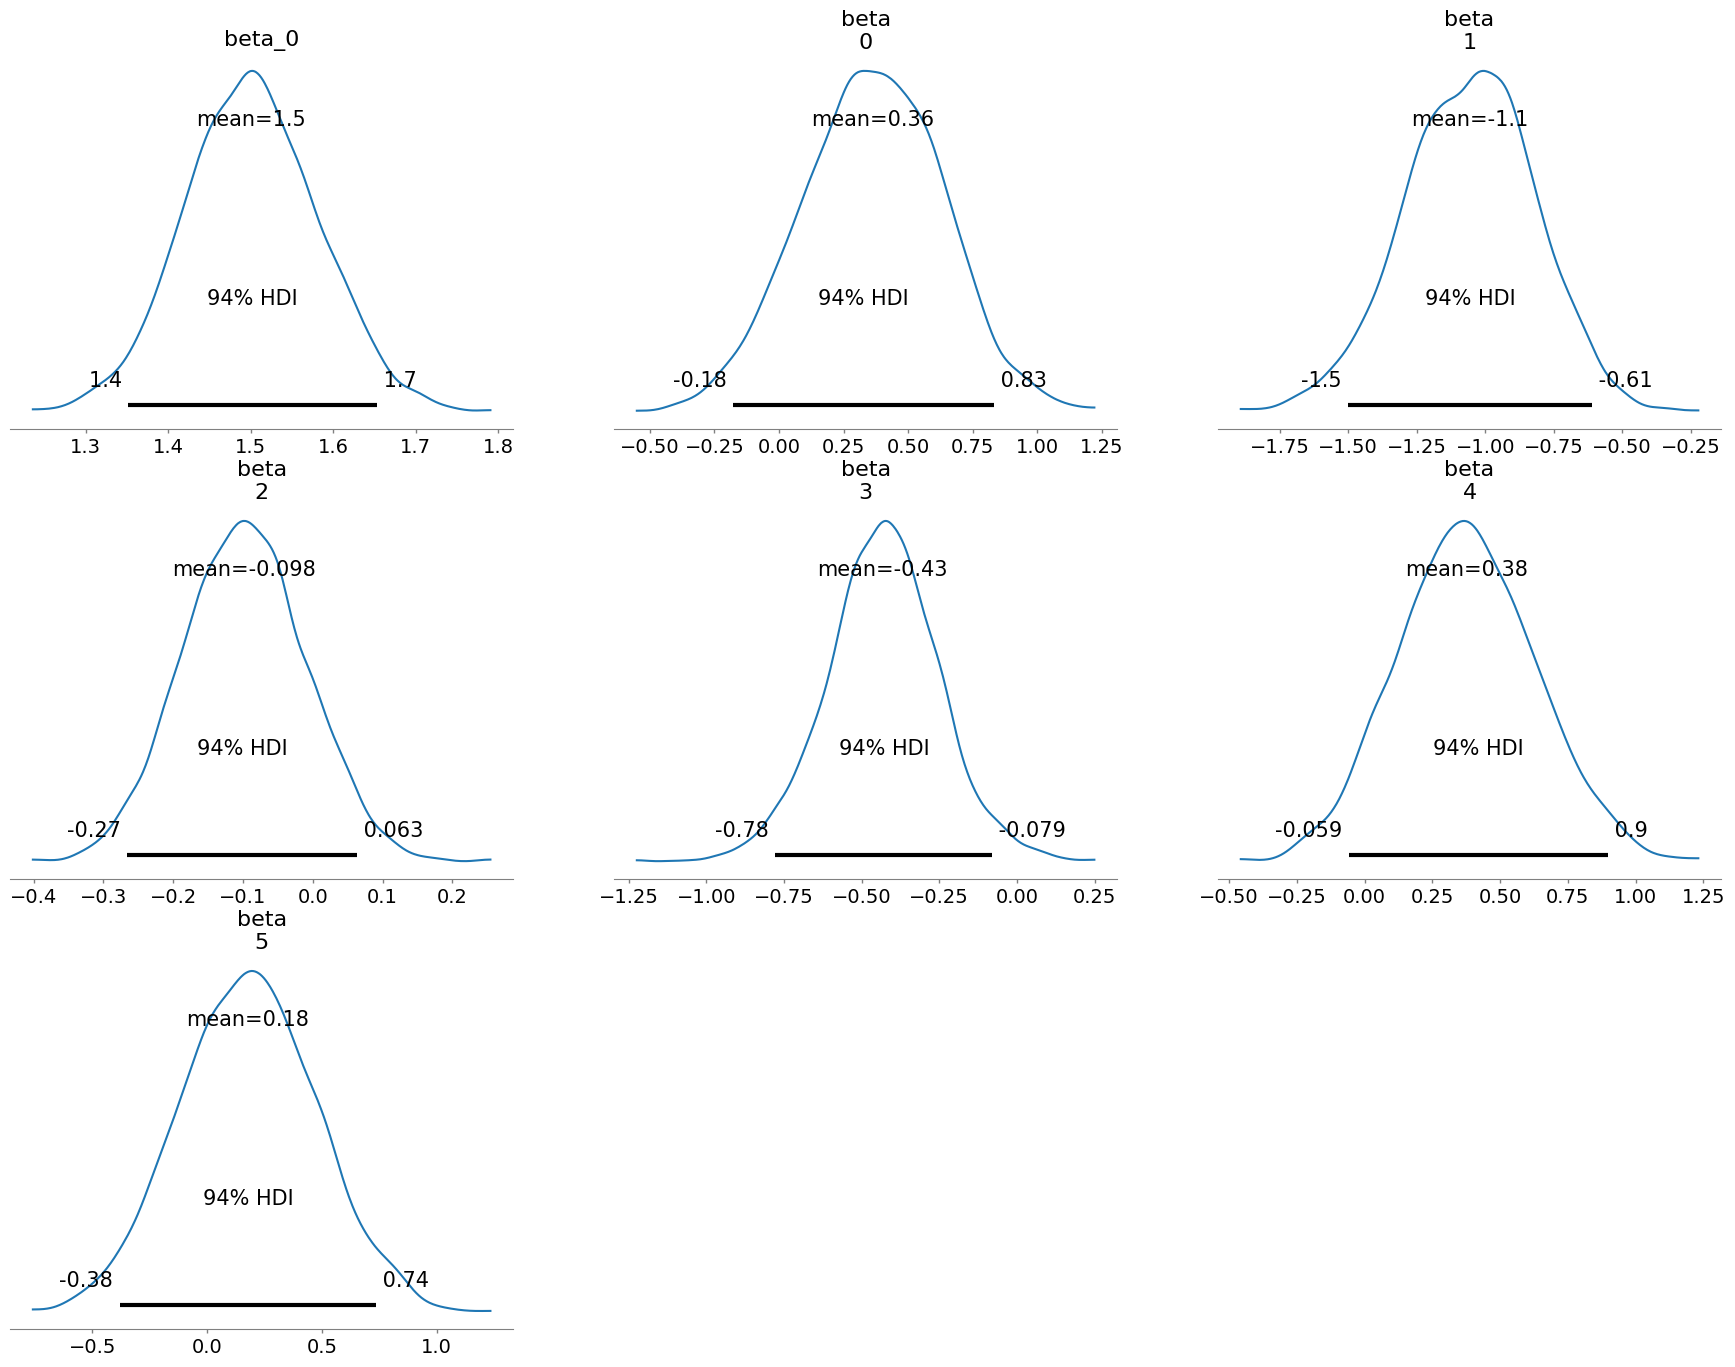

In [8]:
# 4. Compare Priors and Posteriors
az.plot_posterior(trace, var_names=["beta_0", "beta"])
plt.show()

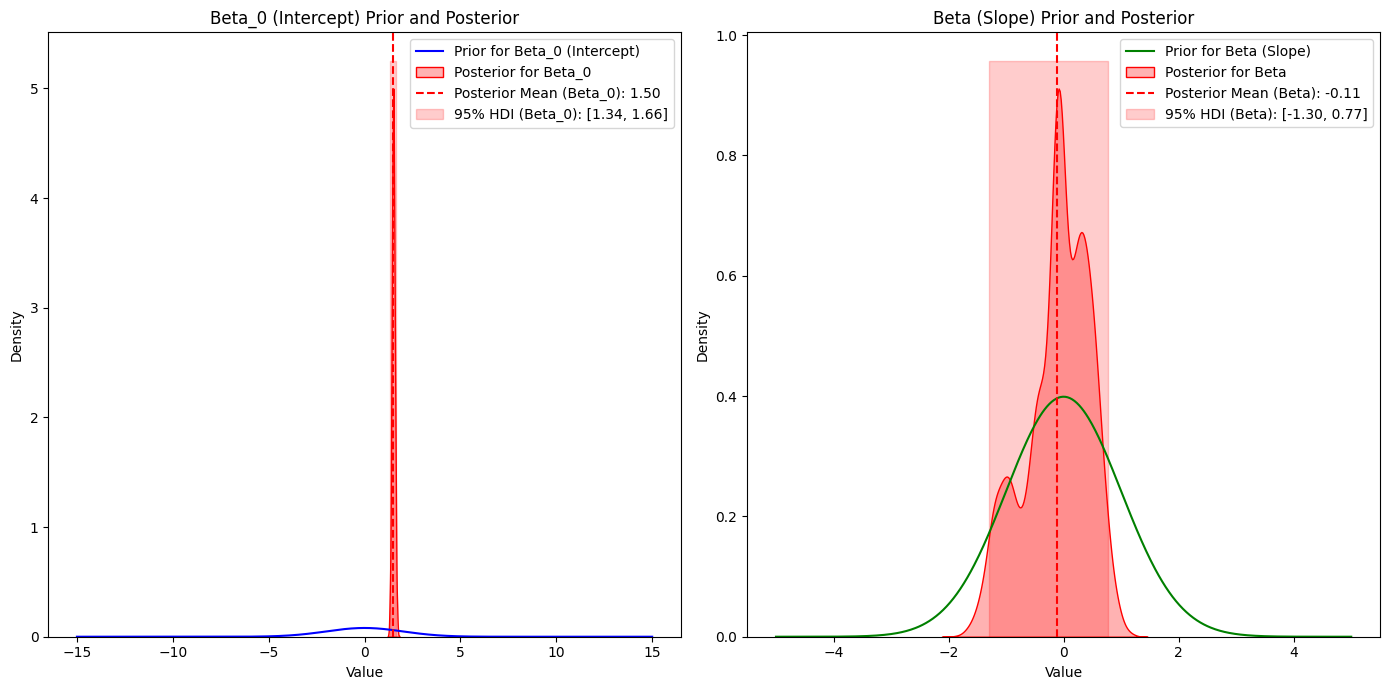

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

# Extract posterior samples from the trace
beta_0_samples = trace.posterior['beta_0'].values.flatten()
beta_1_samples = trace.posterior['beta'].values.flatten()

# Define ranges for prior PDFs
x_beta_0 = np.linspace(-15, 15, 500)
x_beta_1 = np.linspace(-5, 5, 500)

# Prior distributions
prior_beta_0 = np.exp(-0.5 * (x_beta_0 / 2)**2) / (5 * np.sqrt(2 * np.pi))  # N(0, 1/10)
prior_beta_1 = np.exp(-0.5 * (x_beta_1 / 1)**2) / (1 * np.sqrt(2 * np.pi))  # N(0, 1)

# Plot Priors and Posteriors for Beta_0 and Beta_1
plt.figure(figsize=(14, 7))

# Beta_0 (Intercept)
plt.subplot(1, 2, 1)
plt.plot(x_beta_0, prior_beta_0, label="Prior for Beta_0 (Intercept)", color="blue")
sns.kdeplot(beta_0_samples, label="Posterior for Beta_0", color="red", fill=True, alpha=0.3)
plt.title("Beta_0 (Intercept) Prior and Posterior")
plt.xlabel("Value")
plt.ylabel("Density")

# Annotate Prior and Posterior values (mean and credible interval)
mean_beta_0 = np.mean(beta_0_samples)
hdi_beta_0 = np.percentile(beta_0_samples, [2.5, 97.5])
plt.axvline(mean_beta_0, color="red", linestyle="--", label=f"Posterior Mean (Beta_0): {mean_beta_0:.2f}")
plt.fill_betweenx(
    [0, plt.gca().get_ylim()[1]], hdi_beta_0[0], hdi_beta_0[1], color="red", alpha=0.2,
    label=f"95% HDI (Beta_0): [{hdi_beta_0[0]:.2f}, {hdi_beta_0[1]:.2f}]"
)
plt.legend()

# Beta_1 (Slope)
plt.subplot(1, 2, 2)
plt.plot(x_beta_1, prior_beta_1, label="Prior for Beta (Slope)", color="green")
sns.kdeplot(beta_1_samples, label="Posterior for Beta", color="red", fill=True, alpha=0.3)
plt.title("Beta (Slope) Prior and Posterior")
plt.xlabel("Value")
plt.ylabel("Density")

# Annotate Prior and Posterior values (mean and credible interval)
mean_beta_1 = np.mean(beta_1_samples)
hdi_beta_1 = np.percentile(beta_1_samples, [2.5, 97.5])
plt.axvline(mean_beta_1, color="red", linestyle="--", label=f"Posterior Mean (Beta): {mean_beta_1:.2f}")
plt.fill_betweenx(
    [0, plt.gca().get_ylim()[1]], hdi_beta_1[0], hdi_beta_1[1], color="red", alpha=0.2,
    label=f"95% HDI (Beta): [{hdi_beta_1[0]:.2f}, {hdi_beta_1[1]:.2f}]"
)
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y"])


Sampling: [y]


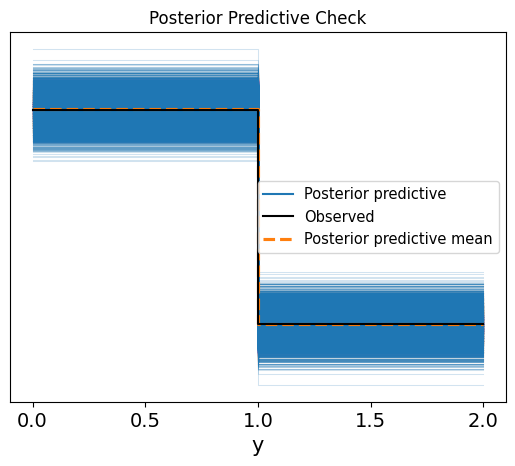

In [11]:
az.plot_ppc(ppc)
plt.title("Posterior Predictive Check")
plt.show()

The PPC here is strongly impacted by the data, as we have seen that the prior is very weak. We can see that it fits the data and seems to predict correctly

# Model with a weak prior

In [18]:
# Calculate the mean of home odds
home_odds_columns = ['B365H', 'BWH', 'IWH', 'PSH', 'VCH', 'WHH']
data['mean_odds_home'] = data[home_odds_columns].mean(axis=1, skipna=True)

# Filter the necessary columns
mean_odds_home = data['mean_odds_home'].values
home_win = data['HomeWin'].values

# 2. Bayesian Logistic Regression Model
with pm.Model() as model:
    # Priors for intercept and coefficient
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)  # Log-odds centered around 0 (p=0.5)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=1)  # Coefficient with moderate variability

    # Logistic regression model (log-odds to probability)
    logit_p = beta_0 + beta_1 * mean_odds_home
    #p = pm.Deterministic('p', pm.math.sigmoid(logit_p))  # Logistic function for probability

    # Likelihood: Observed outcomes are binary (home win: 1, loss/draw: 0)
    y = pm.Bernoulli('y', logit_p=logit_p, observed=home_win)

    # Sampling the posterior
    trace = pm.sample(1000, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


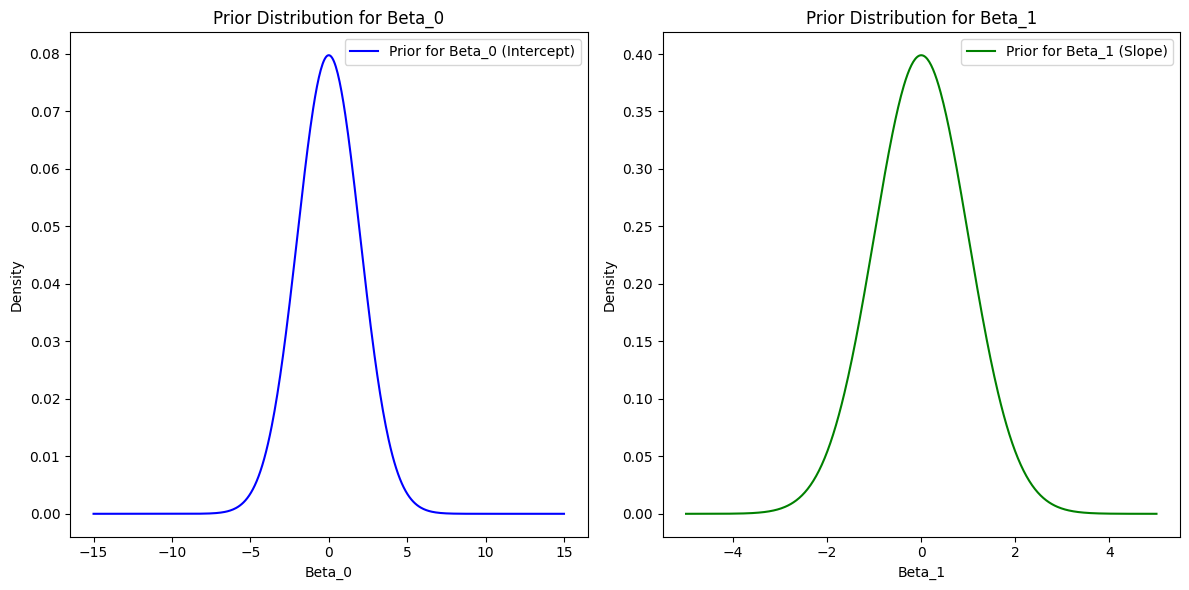

In [19]:

# 3. Plot priors
x_beta_0 = np.linspace(-15, 15, 500)  # Range for intercept
x_beta_1 = np.linspace(-5, 5, 500)   # Range for slope

# Prior distributions
prior_beta_0 = np.exp(-0.5 * (x_beta_0 / 2)**2) / (5 * np.sqrt(2 * np.pi))  # N(0, 5)
prior_beta_1 = np.exp(-0.5 * (x_beta_1 / 1)**2) / (1 * np.sqrt(2 * np.pi))  # N(0, 1)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_beta_0, prior_beta_0, label='Prior for Beta_0 (Intercept)', color='blue')
plt.title('Prior Distribution for Beta_0')
plt.xlabel('Beta_0')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_beta_1, prior_beta_1, label='Prior for Beta_1 (Slope)', color='green')
plt.title('Prior Distribution for Beta_1')
plt.xlabel('Beta_1')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

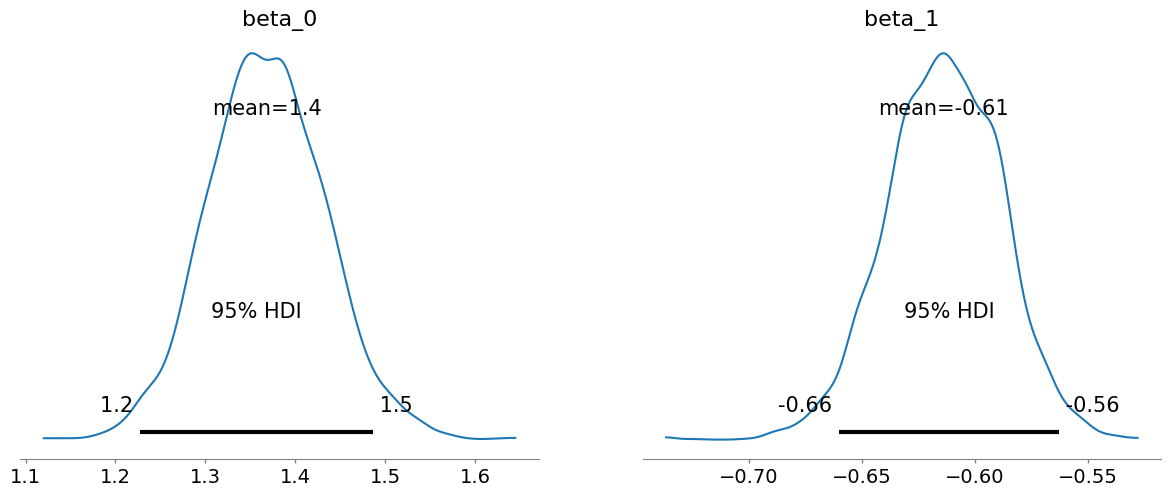

In [20]:
# 4. Plot posterior distributions
pm.plot_posterior(trace, var_names=['beta_0', 'beta_1'], hdi_prob=0.95)
plt.show()

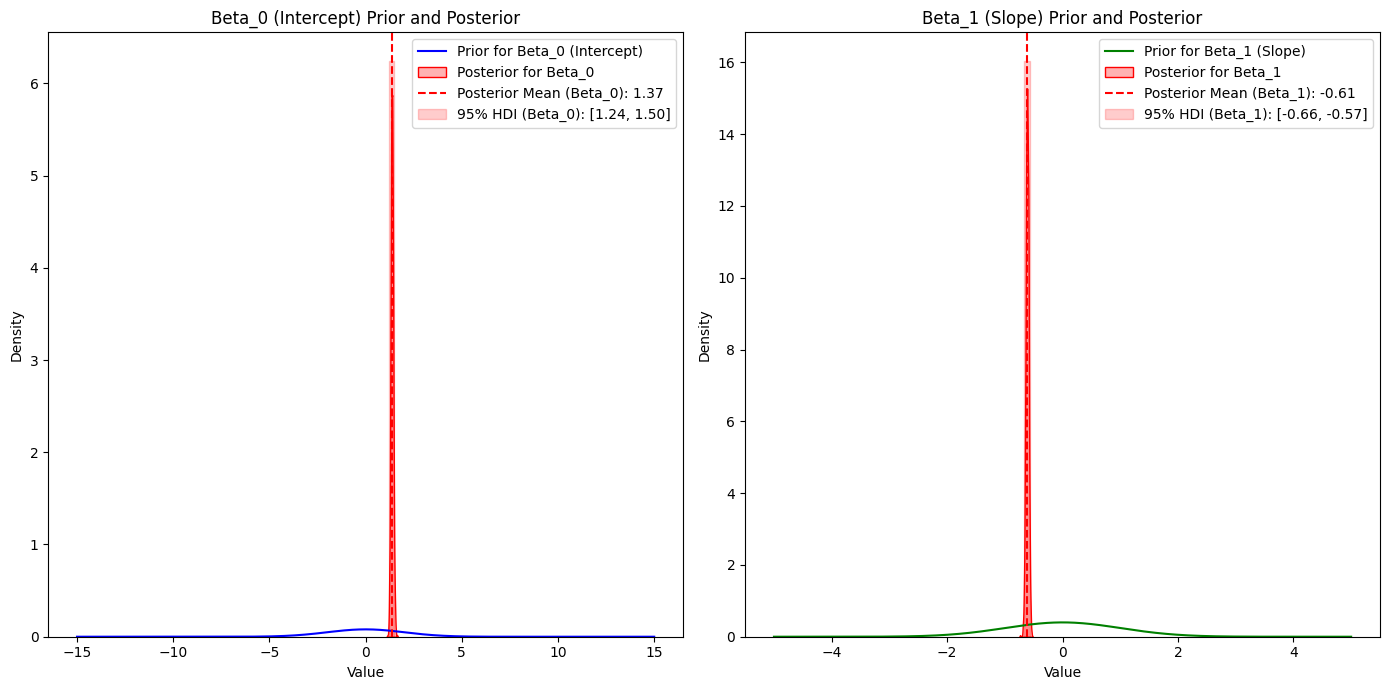

In [21]:

# 5. Compare Priors and Posteriors
# Extract posterior samples from the trace
beta_0_samples = trace.posterior['beta_0'].values.flatten()
beta_1_samples = trace.posterior['beta_1'].values.flatten()

# Define ranges for prior PDFs
x_beta_0 = np.linspace(-15, 15, 500)
x_beta_1 = np.linspace(-5, 5, 500)

# Prior distributions
prior_beta_0 = np.exp(-0.5 * (x_beta_0 / 2)**2) / (5 * np.sqrt(2 * np.pi))  # N(0, 5)
prior_beta_1 = np.exp(-0.5 * (x_beta_1 / 1)**2) / (1 * np.sqrt(2 * np.pi))  # N(0, 1)

# Plot Priors and Posteriors for Beta_0 and Beta_1
plt.figure(figsize=(14, 7))


# Beta_0 (Intercept)
plt.subplot(1, 2, 1)
plt.plot(x_beta_0, prior_beta_0, label="Prior for Beta_0 (Intercept)", color="blue")
sns.kdeplot(beta_0_samples, label="Posterior for Beta_0", color="red", fill=True, alpha=0.3)
plt.title("Beta_0 (Intercept) Prior and Posterior")
plt.xlabel("Value")
plt.ylabel("Density")

# Annotate Prior and Posterior values (mean and credible interval)
mean_beta_0 = np.mean(beta_0_samples)
hdi_beta_0 = np.percentile(beta_0_samples, [2.5, 97.5])
plt.axvline(mean_beta_0, color="red", linestyle="--", label=f"Posterior Mean (Beta_0): {mean_beta_0:.2f}")
plt.fill_betweenx(
    [0, plt.gca().get_ylim()[1]], hdi_beta_0[0], hdi_beta_0[1], color="red", alpha=0.2,
    label=f"95% HDI (Beta_0): [{hdi_beta_0[0]:.2f}, {hdi_beta_0[1]:.2f}]"
)
plt.legend()

# Beta_1 (Slope)
plt.subplot(1, 2, 2)
plt.plot(x_beta_1, prior_beta_1, label="Prior for Beta_1 (Slope)", color="green")
sns.kdeplot(beta_1_samples, label="Posterior for Beta_1", color="red", fill=True, alpha=0.3)
plt.title("Beta_1 (Slope) Prior and Posterior")
plt.xlabel("Value")
plt.ylabel("Density")

# Annotate Prior and Posterior values (mean and credible interval)
mean_beta_1 = np.mean(beta_1_samples)
hdi_beta_1 = np.percentile(beta_1_samples, [2.5, 97.5])
plt.axvline(mean_beta_1, color="red", linestyle="--", label=f"Posterior Mean (Beta_1): {mean_beta_1:.2f}")
plt.fill_betweenx(
    [0, plt.gca().get_ylim()[1]], hdi_beta_1[0], hdi_beta_1[1], color="red", alpha=0.2,
    label=f"95% HDI (Beta_1): [{hdi_beta_1[0]:.2f}, {hdi_beta_1[1]:.2f}]"
)
plt.legend()

plt.tight_layout()
plt.show()


## Very uninformative prior

In [22]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y"])


Sampling: [y]


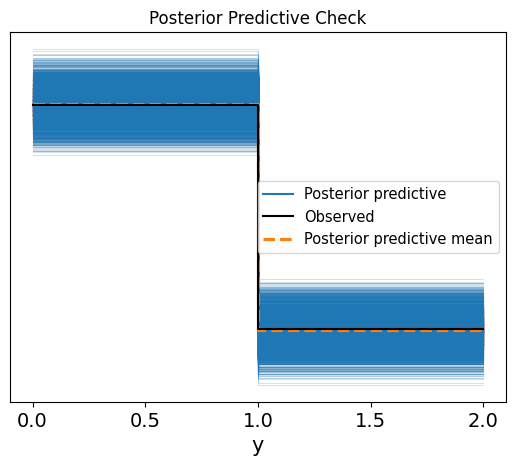

In [23]:
az.plot_ppc(ppc)
plt.title("Posterior Predictive Check")
plt.show()

The PPC here is strongly impacted by the data, as we have seen that the prior is very weak. We can see that it fits the data and seems to predict correctly